In [1]:
import random
import os
from datetime import datetime
from collections import OrderedDict
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.min_rows', 50)

In [15]:
# Path to data location
DATA_DIR = 'data/price-volume-data-for-all-us-stocks-etfs/Data'

# TODO: Update from Small to Regular (delete Small)
if True:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs')
else:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks_Small')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs_Small')

FILE_SUFFIX = '.us.txt'

In [41]:
def get_tickers(dirname):
    tickers = []
    for file in os.listdir(dirname):
        # This dataset includes empty files which we exclude here.
        if os.stat(os.path.join(dirname, file)).st_size > 0:
            tickers.append(file.replace(FILE_SUFFIX, ''))

    return tickers

def get_etf_tickers():
    return sorted(get_tickers(ETF_DATA_DIR))

def get_stock_tickers():
    return sorted(get_tickers(STOCK_DATA_DIR))

def get_all_tickers():
    return sorted(get_etf_tickers() + get_stock_tickers())

def get_csv_data(ticker):
    ticker = ticker.lower()
    
    if ticker in get_etf_tickers():
        dirname = ETF_DATA_DIR
    else:
        dirname = STOCK_DATA_DIR

    result = pd.DataFrame()
    csv = pd.read_csv(os.path.join(dirname, ticker + FILE_SUFFIX))
    result = pd.DataFrame({'date': csv['Date'], 'ticker': ticker, 'price': csv['Close'], 'volume': csv['Volume']})
    result['date'] = result['date'].map(lambda t: datetime.strptime(t, '%Y-%m-%d')).to_numpy()
    result.index = result.date
    
    # Making sure to only include weekdays
    result['dayofweek'] = pd.DatetimeIndex(result.index).dayofweek
    result = result[(result.dayofweek != 5) & (result.dayofweek != 6)]

    return result

In [42]:
t = get_csv_data('spy')
t.head()

,date,ticker,price,volume,dayofweek
date,,,,,
2005-02-25,2005-02-25,spy,105.79,70221808,4
2005-02-28,2005-02-28,spy,105.08,79695344,0
2005-03-01,2005-03-01,spy,105.62,54607412,1
2005-03-02,2005-03-02,spy,105.57,73733090,2
2005-03-03,2005-03-03,spy,105.61,71286823,3


In [43]:
# TODO: 
class EquityData:
    def __init__(self, date_list, price_list):
        self.date = date_list
        self.price = price_list
        self.dates = self.date
        self.prices = self.price

    def __len__(self):
        return len(self.date)
    
    def __getitem__(self, idx):
        return type(self)(self.dates[idx], self.prices[idx])

In [44]:
example_ticker = 'spy'

In [45]:
stocks = {}

In [54]:
from abc import ABC, abstractmethod

class Strategy(ABC):

    def __init__(self):
        self.signals = []

    def buy_signal(self, date):
        self.signals.append([self.ticker, date, 'buy'])
        #print(self.signals[-1])

    def sell_signal(self, date):
        self.signals.append([self.ticker, date, 'sell'])
        #print(self.signals[-1])

    def get_signals(self):
        signals_df = pd.DataFrame(data=self.signals, columns=['ticker', 'date', 'signal'])
        signals_df.index = signals_df.date
        return signals_df
    
    @abstractmethod
    def precalc(self, data):
        pass
    
    @abstractmethod
    def execute(self, data):
        pass

    def plot(self, data):
        pass

In [60]:
class SimpleMovingAvgCrossOverStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()

        self.ticker = ticker
        
        if config:
            self.sma_short = config['sma_short']
            self.sma_long = config['sma_long']
        else:
            self.sma_short = 100
            self.sma_long = 300

        self.invested = False
        
    def precalc(self, data):
        data['sma_short'] = data['price'].rolling(self.sma_short, min_periods=self.sma_short).mean()
        data['sma_long'] = data['price'].rolling(self.sma_long, min_periods=self.sma_long).mean()

    def execute(self, data):
        for _, data in data.iterrows():
            if data['sma_short'] > data['sma_long'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['sma_short'] < data['sma_long'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False
                
    def plot(self, data, plt):
        pass

In [61]:
class BuyAndHoldStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker.lower()
        self.invested = False
        
    def precalc(self, data, ax):
        pass
    
    def execute(self, data):
        for _, data in data.iterrows():
            if not self.invested:
                self.buy_signal(data['date'])
                self.invested = True

In [64]:
class BandStrategy(Strategy):

    def execute(self, data):
        for _, data in data.iterrows():
            if data['price'] < data['band_low'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['price'] > data['band_high'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False
                
    
class BollingerBandStrategy(BandStrategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker
        
        if config:
            pass
        else:
            self.sma = 20
            self.sd = 2

        self.invested = False

    def precalc(self, data):
        data['sma'] = data['price'].rolling(self.sma, min_periods=self.sma).mean()
        data['sd'] = data['price'].rolling(self.sma, min_periods=self.sma).std()
        data['band_high'] = data['sma'] + self.sd * data['sd']
        data['band_low'] = data['sma'] - self.sd * data['sd']

BuyAndHold
1.439644578882692


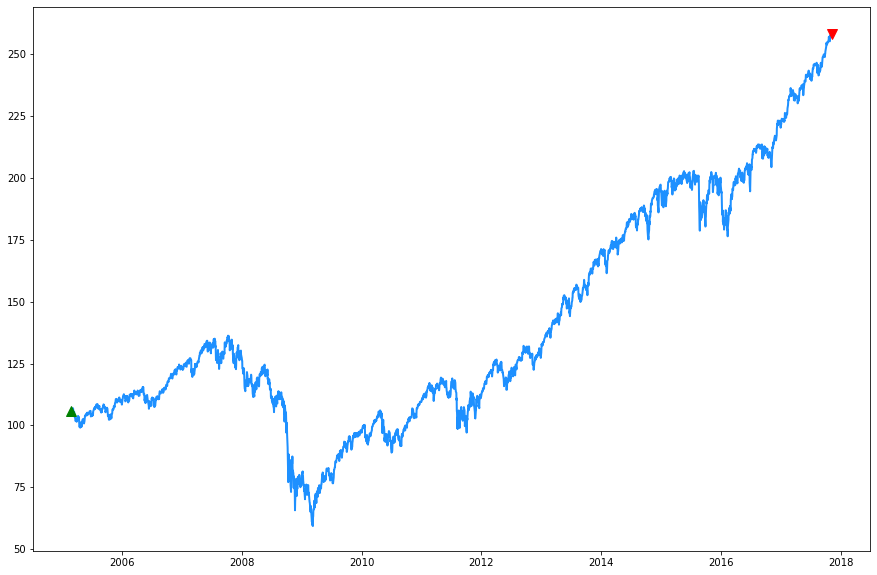

In [167]:
class Backtest():
    
    def __init__(self, strategy_cls, ticker, config={}, start_date=None, end_date=None):
        self.ticker = ticker.lower()
        self.config = config
        self.strategy = strategy_cls(ticker, config)
        self.data = None
        self.signals = None
        self.buys = None
        self.sells = None

    def run(self):
        self.data = get_csv_data(self.ticker)
        self.strategy.precalc(self.data)
        self.strategy.execute(self.data)

        self.signals = self.strategy.get_signals()
        self.buys = self.data.loc[self.signals[self.signals.signal == 'buy'].index]['price']
        self.sells = self.data.loc[self.signals[self.signals.signal == 'sell'].index]['price']
        if len(self.buys) > len(self.sells):
            self.sells = self.sells.append(backtest.data['price'][[-1]])

        return self.calc_return()

    def calc_return(self):
        if not all(self.buys.index < self.sells.index):
            raise Exception('Strategy buys and sells are not consistent.')

        return np.prod(self.sells.values / self.buys.values) - 1

    def plot(self):
        signals = self.data.copy()
        #signals['short_mavg'] = signals['sma_short']
        #signals['long_mavg'] = signals['sma_long']

        fig = plt.figure(figsize=(15,10))

        plt.plot(self.data.date, self.data.price, color='dodgerblue', lw=2., label='price', zorder=0)

        plt.plot(self.data.loc[backtest.buys.index].index, self.data.price[backtest.buys.index], 
                 '^', markersize=10, color='g')
        plt.plot(self.data.loc[backtest.sells.index].index, self.data.price[backtest.sells.index],
                 'v', markersize=10, color='r')

        if False:
            plt.fill_between(signals.date, signals['short_mavg'], signals['long_mavg'],
                             label=f'{30}-day band', color='pink', zorder=-1)

        #buys, sells = strategy(stocks[ticker].prices, **kwargs)
        #roi_value = roi(stocks[ticker].prices, buys, sells)
        #plt.title(f'{ticker.upper()} trades using {strategy.__name__}, ROI: {roi_value}')
        #plt.scatter(stocks[ticker].dates[buys], stocks[ticker].prices[buys],
        #            label='buys', marker='x', c='red', s=256, zorder=2)
        #plt.scatter(stocks[ticker].dates[sells], stocks[ticker].prices[sells],
        #            label='sells', marker='x', c='lime', s=256, zorder=2)

        plt.show()
    
    
example_ticker = 'SPY'

print('BuyAndHold')
backtest = Backtest(BuyAndHoldStrategy, example_ticker)
print(backtest.run())
backtest.plot()


if False:
    print('Bollinger')
    backtest = Backtest(BollingerBandStrategy, example_ticker)
    print(backtest.run())
    backtest.plot()

    print('SMA')
    backtest = Backtest(SimpleMovingAvgCrossOverStrategy, example_ticker)
    print(backtest.run())
    backtest.plot()    

In [ ]:
    def generate_positions(self):
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions[self.symbol] = 100*signals['signal']   # This strategy buys 100 shares
        return positions

In [ ]:
    def backtest_portfolio(self):
        portfolio = self.positions*self.bars['Adj Close']
        pos_diff = self.positions.diff()

        portfolio['holdings'] = (self.positions*self.bars['Adj Close']).sum(axis=1)
        portfolio['cash'] = self.initial_capital - (pos_diff*self.bars['Adj Close']).sum(axis=1).cumsum()

        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio